In [2]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from scipy.special import expit
import wandb


## Multi Layer Perceptron Classification Class

In [7]:
class MLP:
    
    def __init__(self,layer_sizes, batch_size, num_epoches, learning_rate, activation_function, optimization):
        self.layer_sizes = layer_sizes # number of neurons in each layer
        self.num_layers = len(self.layer_sizes) # total number of layers
        self.batch_size = batch_size # only for mini-batch gradient descent
        self.epoches = num_epoches
        self.learning_rate = learning_rate
        self.activation_function = activation_function
        self.optimization = optimization
        
        # initializing weights (needed once only)
        self.initialize_weights()
        
        # validation loss and acc
        self.validation_loss = []
        self.validation_accuracy = []
        
        # training loss and acc
        self.L = []
        self.A = []
        
        print('Initialized values successfully!')
    
    def printParameters(self):
        print('-----------------------------------------------')
        print('Number of Layers       : ',self.num_layers)
        print('Layer sizes            : ',self.layer_sizes)
        print('Batch size             : ',self.batch_size)
        print('Activation Function    : ',self.activation_function)
        print('Optimization Method    : ',self.optimization)
        print('Learning Rate          : ',self.learning_rate)
        print('Num Epoches            : ',self.epoches)
        print('-----------------------------------------------')

    
    # loads the dataframe into the class
    def loadData(self,df):
        self.num_features = df.shape[1]-1
        self.num_classes = df.iloc[:, -1].nunique()
        self.df = df
        print('Loaded Dataframe!')

    # splits the dataframe loaded into train, validation and test sets
    def splitData(self,train_fraction,normalize):
        X = df.iloc[:, :-1].values
        if normalize:
            mean = np.mean(X, axis=0)
            std = np.std(X, axis=0)
            X = (X - mean) / std
        y = df.iloc[:, -1].values
        
        self.X_train, X_temp, self.y_train, y_temp = train_test_split(X, y, test_size=1-train_fraction, random_state=42)
        self.X_val, self.X_test, self.y_val, self.y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)
        print('Splitted data into train, test and val sets!')
        
        
    # returns the one-hot encoded version of a given vector
    def oneHotEncoding(self, y):
        y_encoded = np.zeros((len(y), self.num_classes))
        y_encoded[np.arange(len(y)), y] = 1
        return y_encoded
    
    def categorical(self,x):  
        # Transform probabilities into categorical predictions row-wise, by simply taking the max probability
        categorical = np.argmax(x,axis=1)
        return categorical

# defining activation functions and their derivatives
#--------------------------------------------------------------------------------------------

    # SIGMOID
    def sigmoid(self,z):
        val = 1/(1+np.exp(-z))
        return val
    def sigmoid_prime(self,h):
        # Compute the derivative of sigmoid where h=sigmoid(x)
        return h*(1-h)
    
    # ReLU 
    def ReLU(self, z):
        ret = np.maximum(z, 0)
        if ret.shape!=z.shape:
            print('whaat??')
        return ret
    def ReLU_prime(self, h):
        return np.where(h >= 0, 1, 0)
    
    # tanh
    def hyperbolic_tan(self, z):
#         val = (2/(np.exp(-2*z)+1)) -1
        val = expit(2 * z) - 1

        return val
    def hyperbolic_tan_prime(self, h):
        return 1-h**2
    
    # linear (can change slope and intercept)
    def linear(self, z):
        return z
    def linear_prime(self,h):
        return 1
    
#-----------------activation function for last layer (output) -------------------------------

    def softmax(self,z):
        ar = np.exp(z-np.max(z))
        return ar/ar.sum(axis=1,keepdims=True)
#         exp = np.exp(z - np.max(z))
#         for i in range(len(z)):
#             exp[i]/=np.sum(exp[i])
#         return exp
    


#---------------------------------------------------------------------------------------------

    def activation(self,z):
        if z.any()>=1e2:
            print('z = ',z)
        if self.activation_function=='sigmoid':
            return self.sigmoid(z)
        elif self.activation_function=='ReLU':
            return self.ReLU(z)
        elif self.activation_function=='tanh':
            return self.hyperbolic_tan(z)
        elif self.activation_function=='linear':
            return self.linear(z)
        else:
            raise ValueError("Invalid Activation function")

    def activation_prime(self,h):
        if self.activation_function=='sigmoid':
            return self.sigmoid_prime(h)
        elif self.activation_function=='ReLU':
            return self.ReLU_prime(h)
        elif self.activation_function=='tanh':
            return self.hyperbolic_tan_prime(h)
        elif self.activation_function=='linear':
            return self.linear_prime(h)
        else:
            raise ValueError("Invalid Activation function")

#---------------------------------------------------------------------------------------------


    def loss(self, y_hat, y):
        epsilon = 1e-7
        y_hat = y_hat + epsilon
        # adding small value to avoid underflow
        # Compute the loss along the rows, averaging along the number of samples
        return ((-np.log(y_hat))*y).mean()
    
    def accuracy(self, y_hat, y):  
        # Compute the accuracy along the rows, averaging along the number of samples
        return np.sum(y_hat==(y))/len(y_hat)


    
    def initialize_weights(self):
        self.weights = []
        #weights[i] is a m,n matrix giving weight connecting the i and i+1th layer
        
        min_weight = -1
        max_weight = 1
        for i in range(self.num_layers-1):
            sz = [self.layer_sizes[i],self.layer_sizes[i+1]]
            wt = np.random.uniform(min_weight,max_weight,size=sz)
            self.weights.append(wt)
        
#         self.weights = np.asarray(self.weights)
        
    def initialize_layers(self,batch_size):
        self.hidden_layers = [np.ones((batch_size,layer_size)) for layer_size in layer_sizes]
        
    # takes in a batch of data (num_samples x num_features) and applies feed-forward on it
    def feedforward(self, batch):
        current_layer = batch
        self.hidden_layers[0] = batch
        
        # next_layer = activation(weights . current_leyer) and storing while feed-forward
        for i,weights in enumerate(self.weights):
            current_layer = self.activation(np.dot(current_layer,weights))
            self.hidden_layers[i+1] = current_layer
            
        # softmax of the last layer is the output layer
        self.output_layer = self.softmax(self.hidden_layers[-1])
        
    # goes from the last layer to the 1st layer updating weights according to GD
    def backpropogation(self, y):
        y = self.oneHotEncoding(y)
        # evaluating the last layer error : del
        del_t = -(y - self.output_layer)*self.activation_prime(self.hidden_layers[-1])
        
        for i in range(1,self.num_layers):
            # calculating the gradient of weights and applying gradient-descent
            dJ_dW = np.dot(self.hidden_layers[-i-1].T,del_t)/self.batch_size
            self.weights[-i] = self.weights[-i] - self.learning_rate * dJ_dW
            # updating the error for the next layer 
            del_t = np.dot(del_t,self.weights[-i].T)*self.activation_prime(self.hidden_layers[-i-1])
                    
    def validate(self):
        n,m = self.X_val.shape[0:2]
        self.initialize_layers(batch_size=n)
        self.feedforward(self.X_val)
        val_loss = self.loss(self.output_layer,self.oneHotEncoding(self.y_val))
        val_acc = self.accuracy(self.categorical(self.output_layer),self.y_val)
        self.validation_loss.append(val_loss)
        self.validation_accuracy.append(val_acc)
        
    def mini_batch_GD(self):
            self.initialize_layers(self.batch_size)
            loss_sum = 0
            accuracy_sum = 0
            
            # calculating the total number of batches (acc to batch sizee)
            num_batches = self.X_train.shape[0]/self.batch_size
            ind = np.random.permutation(self.X_train.shape[0])
            
            # splitting the X_train, Y_train into batches
            X_batches = np.array_split(self.X_train[ind], num_batches)
            Y_batches = np.array_split(self.y_train[ind], num_batches)
            data_batches = zip(X_batches,Y_batches)
            
            # performing feed-forward -> saving training loss and accuracy -> back-propogation
            for data_x, data_y in data_batches:
                self.feedforward(data_x)
                loss_sum = loss_sum + self.loss(self.output_layer,self.oneHotEncoding(data_y))
                accuracy_sum = accuracy_sum + self.accuracy(self.categorical(self.output_layer),data_y)
                self.backpropogation(data_y)
            
            loss_train = loss_sum/num_batches
            acc_train = accuracy_sum/num_batches
            
            return loss_train, acc_train
        
    def batch_GD(self):
        self.batch_size = self.X_train.shape[0]
        loss_train, acc_train = self.mini_batch_GD()
        return loss_train, acc_train
        
    def SGD(self):
        self.batch_size = 1
        loss_train, acc_train = self.mini_batch_GD()
        return loss_train, acc_train
    
    # general method for optimization (batch/mini-batch/SGD)
    def optimize(self):
        if self.optimization=='mini-batch':
            return self.mini_batch_GD()
        elif self.optimization=='batch':
            return self.batch_GD()
        elif self.optimization=='SGD':
            return self.SGD()
    
    def fit(self):
        for epoch in range(self.epoches):
            # Gradient Descent
            loss_train, acc_train = self.optimize()
            
            # calculating accuracy and loss for current epoch and saving them
            self.L.append(loss_train)
            self.A.append(acc_train)
            
            # testing the current model on validation set and saving the loss and accuracy
            self.validate()
            print('Epoch : ',epoch+1,' loss : ',loss_train.round(3),' acc : ',acc_train.round(3))
#             wandb.log({"acc": acc_train.round(3), "loss": loss_train.round(3)})
            
            
    def predict(self):
        self.feedforward(self.X_test)
        cr = classification_report(self.categorical(self.output_layer),self.y_test,zero_division=1)
        self.predictions = self.categorical(self.output_layer)
        print('------------------------------------------------------\n',cr,'\n------------------------------------------------------\n')

                

## Loading the dataset

In [8]:
# loading the dataset
file_path = './WineQT.csv'

data = pd.read_csv(file_path)
df = pd.DataFrame(data)
df = df.drop(df.columns[-1], axis=1)
df['quality'] = df['quality']-3


## Creating MLP object with specified hyperparameters

In [15]:

# parameters for the model
# the 1st and last element of layer_sizes correspond to number of features and number of outputs
layer_sizes = [11,5,5,6]
batch_size = 100
num_epoches = 100
learning_rate = 0.02
activation_function = 'ReLU'
optimization = 'mini-batch'

# creating the model object
mlp = MLP(layer_sizes=layer_sizes,
          batch_size=batch_size,
          num_epoches=num_epoches,
          learning_rate=learning_rate,
          activation_function=activation_function,
          optimization=optimization
         )

mlp.loadData(df)
mlp.splitData(0.8,True)
mlp.printParameters()


Initialized values successfully!
Loaded Dataframe!
Splitted data into train, test and val sets!
-----------------------------------------------
Number of Layers       :  4
Layer sizes            :  [11, 5, 5, 6]
Batch size             :  100
Activation Function    :  ReLU
Optimization Method    :  mini-batch
Learning Rate          :  0.02
Num Epoches            :  100
-----------------------------------------------


In [16]:
mlp.fit()

Epoch :  1  loss :  0.299  acc :  0.094
Epoch :  2  loss :  0.294  acc :  0.115
Epoch :  3  loss :  0.289  acc :  0.127
Epoch :  4  loss :  0.284  acc :  0.185
Epoch :  5  loss :  0.28  acc :  0.195
Epoch :  6  loss :  0.276  acc :  0.221
Epoch :  7  loss :  0.271  acc :  0.237
Epoch :  8  loss :  0.267  acc :  0.237
Epoch :  9  loss :  0.263  acc :  0.237
Epoch :  10  loss :  0.259  acc :  0.254
Epoch :  11  loss :  0.256  acc :  0.292
Epoch :  12  loss :  0.252  acc :  0.339
Epoch :  13  loss :  0.248  acc :  0.359
Epoch :  14  loss :  0.245  acc :  0.366
Epoch :  15  loss :  0.242  acc :  0.354
Epoch :  16  loss :  0.24  acc :  0.358
Epoch :  17  loss :  0.237  acc :  0.37
Epoch :  18  loss :  0.234  acc :  0.373
Epoch :  19  loss :  0.232  acc :  0.379
Epoch :  20  loss :  0.229  acc :  0.382
Epoch :  21  loss :  0.227  acc :  0.388
Epoch :  22  loss :  0.225  acc :  0.396
Epoch :  23  loss :  0.222  acc :  0.401
Epoch :  24  loss :  0.22  acc :  0.4
Epoch :  25  loss :  0.218  acc

## Plotting Training and Validation Accuracy and Loss

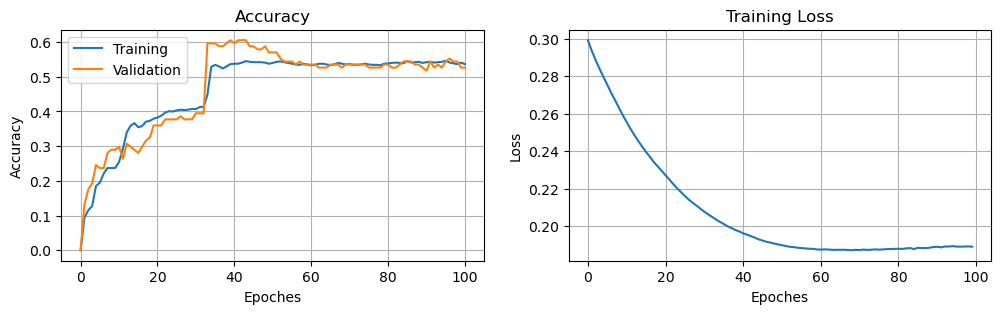

In [17]:
plt.figure(figsize=(12,3))
plt.subplot(1,2,2)
plt.plot(mlp.L)
plt.title('Training Loss')
plt.grid()
plt.xlabel('Epoches')
plt.ylabel('Loss')

# adding base condition to get initial accuracy of 0
mlp.A.insert(0,0)
mlp.validation_accuracy.insert(0,0)

plt.subplot(1,2,1)
plt.plot(mlp.A,label='Training')
plt.plot(mlp.validation_accuracy,label='Validation')
plt.title('Accuracy')
plt.grid()
plt.xlabel('Epoches')
plt.ylabel('Accuracy')
plt.legend()

plt.show()



## 2.3 Evaluating the Model on Test Dataset

In [18]:
mlp.predict()
print(mlp.predictions)

------------------------------------------------------
               precision    recall  f1-score   support

           1       0.00      1.00      0.00         0
           2       0.66      0.70      0.68        47
           3       0.57      0.50      0.53        50
           4       0.38      0.33      0.35        18
           5       0.00      1.00      0.00         0

    accuracy                           0.56       115
   macro avg       0.32      0.71      0.31       115
weighted avg       0.58      0.56      0.56       115
 
------------------------------------------------------

[4 3 2 3 2 3 2 3 3 2 3 4 3 4 2 3 2 3 2 2 2 3 2 3 3 2 2 3 3 2 2 2 4 2 3 3 3
 2 3 3 2 3 2 3 3 3 3 4 3 4 3 3 2 2 3 2 4 4 3 2 2 2 4 4 2 3 2 2 2 4 2 2 3 3
 2 3 4 2 2 2 2 2 3 2 2 3 2 4 3 3 2 3 3 3 2 3 4 3 4 3 2 3 3 3 2 3 3 2 4 2 4
 3 2 4 3]


### Comparison with the Logistic Regression Model

The final accuracies of both, the *Multi Layer Perceptron* model as well as the *Logistic Regression Model* are quite close and similar. Below given is the classification report from the logistic regression model (for learning rate = 0.001 and num_epoches = 100)
                
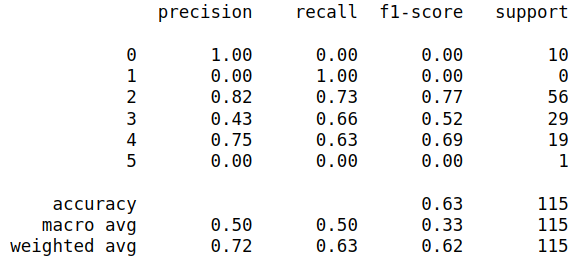



# WANDB logging

In [4]:
i = 0
lr_list = [0.001,0.005,0.01,0.015,0.02,0.05]
af_list = ['tanh','ReLU','sigmoid']

for lr in lr_list:
    for af in af_list:
        for bs in range(100,300,50):
            print(i)
            i = i + 1
            wandb.init(
                # set the wandb project where this run will be logged
                project="MLPClassification",

                # track hyperparameters and run metadata
                config={
                'layer_sizes' : [11,5,5,6],
                'batch_size' : bs,
                'num_epoches' : 100,
                'learning_rate' : lr,
                'activation_function' : af,
                'optimization' : 'mini-batch'
                }
            )



            # parameters for the model
            # the 1st and last element of layer_sizes correspond to number of features and number of outputs
            layer_sizes = [11,5,5,6]
            batch_size = bs
            num_epoches = 100
            learning_rate = lr
            activation_function = af
            optimization = 'mini-batch'

            # creating the model object
            mlp = MLP(layer_sizes=layer_sizes,
                      batch_size=batch_size,
                      num_epoches=num_epoches,
                      learning_rate=learning_rate,
                      activation_function=activation_function,
                      optimization=optimization
                     )

            mlp.loadData(df)
            mlp.splitData(0.8,True)
            mlp.printParameters()
            mlp.fit()
            wandb.finish()


0


wandb: Currently logged in as: tejas591995. Use `wandb login --relogin` to force relogin


Initialized values successfully!
Loaded Dataframe!
Splitted data into train, test and val sets!
-----------------------------------------------
Number of Layers       :  4
Layer sizes            :  [11, 5, 5, 6]
Batch size             :  100
Activation Function    :  tanh
Optimization Method    :  mini-batch
Learning Rate          :  0.001
Num Epoches            :  100
-----------------------------------------------


1


Initialized values successfully!
Loaded Dataframe!
Splitted data into train, test and val sets!
-----------------------------------------------
Number of Layers       :  4
Layer sizes            :  [11, 5, 5, 6]
Batch size             :  150
Activation Function    :  tanh
Optimization Method    :  mini-batch
Learning Rate          :  0.001
Num Epoches            :  100
-----------------------------------------------


2


Initialized values successfully!
Loaded Dataframe!
Splitted data into train, test and val sets!
-----------------------------------------------
Number of Layers       :  4
Layer sizes            :  [11, 5, 5, 6]
Batch size             :  200
Activation Function    :  tanh
Optimization Method    :  mini-batch
Learning Rate          :  0.001
Num Epoches            :  100
-----------------------------------------------


3


Initialized values successfully!
Loaded Dataframe!
Splitted data into train, test and val sets!
-----------------------------------------------
Number of Layers       :  4
Layer sizes            :  [11, 5, 5, 6]
Batch size             :  250
Activation Function    :  tanh
Optimization Method    :  mini-batch
Learning Rate          :  0.001
Num Epoches            :  100
-----------------------------------------------


4


Initialized values successfully!
Loaded Dataframe!
Splitted data into train, test and val sets!
-----------------------------------------------
Number of Layers       :  4
Layer sizes            :  [11, 5, 5, 6]
Batch size             :  100
Activation Function    :  ReLU
Optimization Method    :  mini-batch
Learning Rate          :  0.001
Num Epoches            :  100
-----------------------------------------------


5


Initialized values successfully!
Loaded Dataframe!
Splitted data into train, test and val sets!
-----------------------------------------------
Number of Layers       :  4
Layer sizes            :  [11, 5, 5, 6]
Batch size             :  150
Activation Function    :  ReLU
Optimization Method    :  mini-batch
Learning Rate          :  0.001
Num Epoches            :  100
-----------------------------------------------


6


Initialized values successfully!
Loaded Dataframe!
Splitted data into train, test and val sets!
-----------------------------------------------
Number of Layers       :  4
Layer sizes            :  [11, 5, 5, 6]
Batch size             :  200
Activation Function    :  ReLU
Optimization Method    :  mini-batch
Learning Rate          :  0.001
Num Epoches            :  100
-----------------------------------------------


7


Initialized values successfully!
Loaded Dataframe!
Splitted data into train, test and val sets!
-----------------------------------------------
Number of Layers       :  4
Layer sizes            :  [11, 5, 5, 6]
Batch size             :  250
Activation Function    :  ReLU
Optimization Method    :  mini-batch
Learning Rate          :  0.001
Num Epoches            :  100
-----------------------------------------------


8


Initialized values successfully!
Loaded Dataframe!
Splitted data into train, test and val sets!
-----------------------------------------------
Number of Layers       :  4
Layer sizes            :  [11, 5, 5, 6]
Batch size             :  100
Activation Function    :  sigmoid
Optimization Method    :  mini-batch
Learning Rate          :  0.001
Num Epoches            :  100
-----------------------------------------------


9


Initialized values successfully!
Loaded Dataframe!
Splitted data into train, test and val sets!
-----------------------------------------------
Number of Layers       :  4
Layer sizes            :  [11, 5, 5, 6]
Batch size             :  150
Activation Function    :  sigmoid
Optimization Method    :  mini-batch
Learning Rate          :  0.001
Num Epoches            :  100
-----------------------------------------------


10


Initialized values successfully!
Loaded Dataframe!
Splitted data into train, test and val sets!
-----------------------------------------------
Number of Layers       :  4
Layer sizes            :  [11, 5, 5, 6]
Batch size             :  200
Activation Function    :  sigmoid
Optimization Method    :  mini-batch
Learning Rate          :  0.001
Num Epoches            :  100
-----------------------------------------------


11


Initialized values successfully!
Loaded Dataframe!
Splitted data into train, test and val sets!
-----------------------------------------------
Number of Layers       :  4
Layer sizes            :  [11, 5, 5, 6]
Batch size             :  250
Activation Function    :  sigmoid
Optimization Method    :  mini-batch
Learning Rate          :  0.001
Num Epoches            :  100
-----------------------------------------------


12


Initialized values successfully!
Loaded Dataframe!
Splitted data into train, test and val sets!
-----------------------------------------------
Number of Layers       :  4
Layer sizes            :  [11, 5, 5, 6]
Batch size             :  100
Activation Function    :  tanh
Optimization Method    :  mini-batch
Learning Rate          :  0.005
Num Epoches            :  100
-----------------------------------------------


13


Initialized values successfully!
Loaded Dataframe!
Splitted data into train, test and val sets!
-----------------------------------------------
Number of Layers       :  4
Layer sizes            :  [11, 5, 5, 6]
Batch size             :  150
Activation Function    :  tanh
Optimization Method    :  mini-batch
Learning Rate          :  0.005
Num Epoches            :  100
-----------------------------------------------


14


Initialized values successfully!
Loaded Dataframe!
Splitted data into train, test and val sets!
-----------------------------------------------
Number of Layers       :  4
Layer sizes            :  [11, 5, 5, 6]
Batch size             :  200
Activation Function    :  tanh
Optimization Method    :  mini-batch
Learning Rate          :  0.005
Num Epoches            :  100
-----------------------------------------------


15


Initialized values successfully!
Loaded Dataframe!
Splitted data into train, test and val sets!
-----------------------------------------------
Number of Layers       :  4
Layer sizes            :  [11, 5, 5, 6]
Batch size             :  250
Activation Function    :  tanh
Optimization Method    :  mini-batch
Learning Rate          :  0.005
Num Epoches            :  100
-----------------------------------------------


16


Initialized values successfully!
Loaded Dataframe!
Splitted data into train, test and val sets!
-----------------------------------------------
Number of Layers       :  4
Layer sizes            :  [11, 5, 5, 6]
Batch size             :  100
Activation Function    :  ReLU
Optimization Method    :  mini-batch
Learning Rate          :  0.005
Num Epoches            :  100
-----------------------------------------------


17


Initialized values successfully!
Loaded Dataframe!
Splitted data into train, test and val sets!
-----------------------------------------------
Number of Layers       :  4
Layer sizes            :  [11, 5, 5, 6]
Batch size             :  150
Activation Function    :  ReLU
Optimization Method    :  mini-batch
Learning Rate          :  0.005
Num Epoches            :  100
-----------------------------------------------


18


Initialized values successfully!
Loaded Dataframe!
Splitted data into train, test and val sets!
-----------------------------------------------
Number of Layers       :  4
Layer sizes            :  [11, 5, 5, 6]
Batch size             :  200
Activation Function    :  ReLU
Optimization Method    :  mini-batch
Learning Rate          :  0.005
Num Epoches            :  100
-----------------------------------------------


19


Initialized values successfully!
Loaded Dataframe!
Splitted data into train, test and val sets!
-----------------------------------------------
Number of Layers       :  4
Layer sizes            :  [11, 5, 5, 6]
Batch size             :  250
Activation Function    :  ReLU
Optimization Method    :  mini-batch
Learning Rate          :  0.005
Num Epoches            :  100
-----------------------------------------------


20


Initialized values successfully!
Loaded Dataframe!
Splitted data into train, test and val sets!
-----------------------------------------------
Number of Layers       :  4
Layer sizes            :  [11, 5, 5, 6]
Batch size             :  100
Activation Function    :  sigmoid
Optimization Method    :  mini-batch
Learning Rate          :  0.005
Num Epoches            :  100
-----------------------------------------------


21


Initialized values successfully!
Loaded Dataframe!
Splitted data into train, test and val sets!
-----------------------------------------------
Number of Layers       :  4
Layer sizes            :  [11, 5, 5, 6]
Batch size             :  150
Activation Function    :  sigmoid
Optimization Method    :  mini-batch
Learning Rate          :  0.005
Num Epoches            :  100
-----------------------------------------------


22


Initialized values successfully!
Loaded Dataframe!
Splitted data into train, test and val sets!
-----------------------------------------------
Number of Layers       :  4
Layer sizes            :  [11, 5, 5, 6]
Batch size             :  200
Activation Function    :  sigmoid
Optimization Method    :  mini-batch
Learning Rate          :  0.005
Num Epoches            :  100
-----------------------------------------------


23


Initialized values successfully!
Loaded Dataframe!
Splitted data into train, test and val sets!
-----------------------------------------------
Number of Layers       :  4
Layer sizes            :  [11, 5, 5, 6]
Batch size             :  250
Activation Function    :  sigmoid
Optimization Method    :  mini-batch
Learning Rate          :  0.005
Num Epoches            :  100
-----------------------------------------------


24


Initialized values successfully!
Loaded Dataframe!
Splitted data into train, test and val sets!
-----------------------------------------------
Number of Layers       :  4
Layer sizes            :  [11, 5, 5, 6]
Batch size             :  100
Activation Function    :  tanh
Optimization Method    :  mini-batch
Learning Rate          :  0.01
Num Epoches            :  100
-----------------------------------------------


25


Initialized values successfully!
Loaded Dataframe!
Splitted data into train, test and val sets!
-----------------------------------------------
Number of Layers       :  4
Layer sizes            :  [11, 5, 5, 6]
Batch size             :  150
Activation Function    :  tanh
Optimization Method    :  mini-batch
Learning Rate          :  0.01
Num Epoches            :  100
-----------------------------------------------


26


Initialized values successfully!
Loaded Dataframe!
Splitted data into train, test and val sets!
-----------------------------------------------
Number of Layers       :  4
Layer sizes            :  [11, 5, 5, 6]
Batch size             :  200
Activation Function    :  tanh
Optimization Method    :  mini-batch
Learning Rate          :  0.01
Num Epoches            :  100
-----------------------------------------------


27


Initialized values successfully!
Loaded Dataframe!
Splitted data into train, test and val sets!
-----------------------------------------------
Number of Layers       :  4
Layer sizes            :  [11, 5, 5, 6]
Batch size             :  250
Activation Function    :  tanh
Optimization Method    :  mini-batch
Learning Rate          :  0.01
Num Epoches            :  100
-----------------------------------------------


28


Initialized values successfully!
Loaded Dataframe!
Splitted data into train, test and val sets!
-----------------------------------------------
Number of Layers       :  4
Layer sizes            :  [11, 5, 5, 6]
Batch size             :  100
Activation Function    :  ReLU
Optimization Method    :  mini-batch
Learning Rate          :  0.01
Num Epoches            :  100
-----------------------------------------------


29


Initialized values successfully!
Loaded Dataframe!
Splitted data into train, test and val sets!
-----------------------------------------------
Number of Layers       :  4
Layer sizes            :  [11, 5, 5, 6]
Batch size             :  150
Activation Function    :  ReLU
Optimization Method    :  mini-batch
Learning Rate          :  0.01
Num Epoches            :  100
-----------------------------------------------


30


Initialized values successfully!
Loaded Dataframe!
Splitted data into train, test and val sets!
-----------------------------------------------
Number of Layers       :  4
Layer sizes            :  [11, 5, 5, 6]
Batch size             :  200
Activation Function    :  ReLU
Optimization Method    :  mini-batch
Learning Rate          :  0.01
Num Epoches            :  100
-----------------------------------------------


31


Initialized values successfully!
Loaded Dataframe!
Splitted data into train, test and val sets!
-----------------------------------------------
Number of Layers       :  4
Layer sizes            :  [11, 5, 5, 6]
Batch size             :  250
Activation Function    :  ReLU
Optimization Method    :  mini-batch
Learning Rate          :  0.01
Num Epoches            :  100
-----------------------------------------------


32


Initialized values successfully!
Loaded Dataframe!
Splitted data into train, test and val sets!
-----------------------------------------------
Number of Layers       :  4
Layer sizes            :  [11, 5, 5, 6]
Batch size             :  100
Activation Function    :  sigmoid
Optimization Method    :  mini-batch
Learning Rate          :  0.01
Num Epoches            :  100
-----------------------------------------------


33


Initialized values successfully!
Loaded Dataframe!
Splitted data into train, test and val sets!
-----------------------------------------------
Number of Layers       :  4
Layer sizes            :  [11, 5, 5, 6]
Batch size             :  150
Activation Function    :  sigmoid
Optimization Method    :  mini-batch
Learning Rate          :  0.01
Num Epoches            :  100
-----------------------------------------------


34


Initialized values successfully!
Loaded Dataframe!
Splitted data into train, test and val sets!
-----------------------------------------------
Number of Layers       :  4
Layer sizes            :  [11, 5, 5, 6]
Batch size             :  200
Activation Function    :  sigmoid
Optimization Method    :  mini-batch
Learning Rate          :  0.01
Num Epoches            :  100
-----------------------------------------------


35


Initialized values successfully!
Loaded Dataframe!
Splitted data into train, test and val sets!
-----------------------------------------------
Number of Layers       :  4
Layer sizes            :  [11, 5, 5, 6]
Batch size             :  250
Activation Function    :  sigmoid
Optimization Method    :  mini-batch
Learning Rate          :  0.01
Num Epoches            :  100
-----------------------------------------------


36


Initialized values successfully!
Loaded Dataframe!
Splitted data into train, test and val sets!
-----------------------------------------------
Number of Layers       :  4
Layer sizes            :  [11, 5, 5, 6]
Batch size             :  100
Activation Function    :  tanh
Optimization Method    :  mini-batch
Learning Rate          :  0.015
Num Epoches            :  100
-----------------------------------------------


37


Initialized values successfully!
Loaded Dataframe!
Splitted data into train, test and val sets!
-----------------------------------------------
Number of Layers       :  4
Layer sizes            :  [11, 5, 5, 6]
Batch size             :  150
Activation Function    :  tanh
Optimization Method    :  mini-batch
Learning Rate          :  0.015
Num Epoches            :  100
-----------------------------------------------


38


Initialized values successfully!
Loaded Dataframe!
Splitted data into train, test and val sets!
-----------------------------------------------
Number of Layers       :  4
Layer sizes            :  [11, 5, 5, 6]
Batch size             :  200
Activation Function    :  tanh
Optimization Method    :  mini-batch
Learning Rate          :  0.015
Num Epoches            :  100
-----------------------------------------------


39


Initialized values successfully!
Loaded Dataframe!
Splitted data into train, test and val sets!
-----------------------------------------------
Number of Layers       :  4
Layer sizes            :  [11, 5, 5, 6]
Batch size             :  250
Activation Function    :  tanh
Optimization Method    :  mini-batch
Learning Rate          :  0.015
Num Epoches            :  100
-----------------------------------------------


40


Initialized values successfully!
Loaded Dataframe!
Splitted data into train, test and val sets!
-----------------------------------------------
Number of Layers       :  4
Layer sizes            :  [11, 5, 5, 6]
Batch size             :  100
Activation Function    :  ReLU
Optimization Method    :  mini-batch
Learning Rate          :  0.015
Num Epoches            :  100
-----------------------------------------------


41


Initialized values successfully!
Loaded Dataframe!
Splitted data into train, test and val sets!
-----------------------------------------------
Number of Layers       :  4
Layer sizes            :  [11, 5, 5, 6]
Batch size             :  150
Activation Function    :  ReLU
Optimization Method    :  mini-batch
Learning Rate          :  0.015
Num Epoches            :  100
-----------------------------------------------


42


Initialized values successfully!
Loaded Dataframe!
Splitted data into train, test and val sets!
-----------------------------------------------
Number of Layers       :  4
Layer sizes            :  [11, 5, 5, 6]
Batch size             :  200
Activation Function    :  ReLU
Optimization Method    :  mini-batch
Learning Rate          :  0.015
Num Epoches            :  100
-----------------------------------------------


43


Initialized values successfully!
Loaded Dataframe!
Splitted data into train, test and val sets!
-----------------------------------------------
Number of Layers       :  4
Layer sizes            :  [11, 5, 5, 6]
Batch size             :  250
Activation Function    :  ReLU
Optimization Method    :  mini-batch
Learning Rate          :  0.015
Num Epoches            :  100
-----------------------------------------------


44


Initialized values successfully!
Loaded Dataframe!
Splitted data into train, test and val sets!
-----------------------------------------------
Number of Layers       :  4
Layer sizes            :  [11, 5, 5, 6]
Batch size             :  100
Activation Function    :  sigmoid
Optimization Method    :  mini-batch
Learning Rate          :  0.015
Num Epoches            :  100
-----------------------------------------------


45


Initialized values successfully!
Loaded Dataframe!
Splitted data into train, test and val sets!
-----------------------------------------------
Number of Layers       :  4
Layer sizes            :  [11, 5, 5, 6]
Batch size             :  150
Activation Function    :  sigmoid
Optimization Method    :  mini-batch
Learning Rate          :  0.015
Num Epoches            :  100
-----------------------------------------------


46


Initialized values successfully!
Loaded Dataframe!
Splitted data into train, test and val sets!
-----------------------------------------------
Number of Layers       :  4
Layer sizes            :  [11, 5, 5, 6]
Batch size             :  200
Activation Function    :  sigmoid
Optimization Method    :  mini-batch
Learning Rate          :  0.015
Num Epoches            :  100
-----------------------------------------------


47


Initialized values successfully!
Loaded Dataframe!
Splitted data into train, test and val sets!
-----------------------------------------------
Number of Layers       :  4
Layer sizes            :  [11, 5, 5, 6]
Batch size             :  250
Activation Function    :  sigmoid
Optimization Method    :  mini-batch
Learning Rate          :  0.015
Num Epoches            :  100
-----------------------------------------------


48


Initialized values successfully!
Loaded Dataframe!
Splitted data into train, test and val sets!
-----------------------------------------------
Number of Layers       :  4
Layer sizes            :  [11, 5, 5, 6]
Batch size             :  100
Activation Function    :  tanh
Optimization Method    :  mini-batch
Learning Rate          :  0.02
Num Epoches            :  100
-----------------------------------------------


49


Initialized values successfully!
Loaded Dataframe!
Splitted data into train, test and val sets!
-----------------------------------------------
Number of Layers       :  4
Layer sizes            :  [11, 5, 5, 6]
Batch size             :  150
Activation Function    :  tanh
Optimization Method    :  mini-batch
Learning Rate          :  0.02
Num Epoches            :  100
-----------------------------------------------


50


Initialized values successfully!
Loaded Dataframe!
Splitted data into train, test and val sets!
-----------------------------------------------
Number of Layers       :  4
Layer sizes            :  [11, 5, 5, 6]
Batch size             :  200
Activation Function    :  tanh
Optimization Method    :  mini-batch
Learning Rate          :  0.02
Num Epoches            :  100
-----------------------------------------------


51


Initialized values successfully!
Loaded Dataframe!
Splitted data into train, test and val sets!
-----------------------------------------------
Number of Layers       :  4
Layer sizes            :  [11, 5, 5, 6]
Batch size             :  250
Activation Function    :  tanh
Optimization Method    :  mini-batch
Learning Rate          :  0.02
Num Epoches            :  100
-----------------------------------------------


52


Initialized values successfully!
Loaded Dataframe!
Splitted data into train, test and val sets!
-----------------------------------------------
Number of Layers       :  4
Layer sizes            :  [11, 5, 5, 6]
Batch size             :  100
Activation Function    :  ReLU
Optimization Method    :  mini-batch
Learning Rate          :  0.02
Num Epoches            :  100
-----------------------------------------------


53


Initialized values successfully!
Loaded Dataframe!
Splitted data into train, test and val sets!
-----------------------------------------------
Number of Layers       :  4
Layer sizes            :  [11, 5, 5, 6]
Batch size             :  150
Activation Function    :  ReLU
Optimization Method    :  mini-batch
Learning Rate          :  0.02
Num Epoches            :  100
-----------------------------------------------


54


Initialized values successfully!
Loaded Dataframe!
Splitted data into train, test and val sets!
-----------------------------------------------
Number of Layers       :  4
Layer sizes            :  [11, 5, 5, 6]
Batch size             :  200
Activation Function    :  ReLU
Optimization Method    :  mini-batch
Learning Rate          :  0.02
Num Epoches            :  100
-----------------------------------------------


55


Initialized values successfully!
Loaded Dataframe!
Splitted data into train, test and val sets!
-----------------------------------------------
Number of Layers       :  4
Layer sizes            :  [11, 5, 5, 6]
Batch size             :  250
Activation Function    :  ReLU
Optimization Method    :  mini-batch
Learning Rate          :  0.02
Num Epoches            :  100
-----------------------------------------------


56


Initialized values successfully!
Loaded Dataframe!
Splitted data into train, test and val sets!
-----------------------------------------------
Number of Layers       :  4
Layer sizes            :  [11, 5, 5, 6]
Batch size             :  100
Activation Function    :  sigmoid
Optimization Method    :  mini-batch
Learning Rate          :  0.02
Num Epoches            :  100
-----------------------------------------------


57


Initialized values successfully!
Loaded Dataframe!
Splitted data into train, test and val sets!
-----------------------------------------------
Number of Layers       :  4
Layer sizes            :  [11, 5, 5, 6]
Batch size             :  150
Activation Function    :  sigmoid
Optimization Method    :  mini-batch
Learning Rate          :  0.02
Num Epoches            :  100
-----------------------------------------------


58


Initialized values successfully!
Loaded Dataframe!
Splitted data into train, test and val sets!
-----------------------------------------------
Number of Layers       :  4
Layer sizes            :  [11, 5, 5, 6]
Batch size             :  200
Activation Function    :  sigmoid
Optimization Method    :  mini-batch
Learning Rate          :  0.02
Num Epoches            :  100
-----------------------------------------------


59


Initialized values successfully!
Loaded Dataframe!
Splitted data into train, test and val sets!
-----------------------------------------------
Number of Layers       :  4
Layer sizes            :  [11, 5, 5, 6]
Batch size             :  250
Activation Function    :  sigmoid
Optimization Method    :  mini-batch
Learning Rate          :  0.02
Num Epoches            :  100
-----------------------------------------------


60


Initialized values successfully!
Loaded Dataframe!
Splitted data into train, test and val sets!
-----------------------------------------------
Number of Layers       :  4
Layer sizes            :  [11, 5, 5, 6]
Batch size             :  100
Activation Function    :  tanh
Optimization Method    :  mini-batch
Learning Rate          :  0.05
Num Epoches            :  100
-----------------------------------------------


61


Initialized values successfully!
Loaded Dataframe!
Splitted data into train, test and val sets!
-----------------------------------------------
Number of Layers       :  4
Layer sizes            :  [11, 5, 5, 6]
Batch size             :  150
Activation Function    :  tanh
Optimization Method    :  mini-batch
Learning Rate          :  0.05
Num Epoches            :  100
-----------------------------------------------


62


Initialized values successfully!
Loaded Dataframe!
Splitted data into train, test and val sets!
-----------------------------------------------
Number of Layers       :  4
Layer sizes            :  [11, 5, 5, 6]
Batch size             :  200
Activation Function    :  tanh
Optimization Method    :  mini-batch
Learning Rate          :  0.05
Num Epoches            :  100
-----------------------------------------------


63


Initialized values successfully!
Loaded Dataframe!
Splitted data into train, test and val sets!
-----------------------------------------------
Number of Layers       :  4
Layer sizes            :  [11, 5, 5, 6]
Batch size             :  250
Activation Function    :  tanh
Optimization Method    :  mini-batch
Learning Rate          :  0.05
Num Epoches            :  100
-----------------------------------------------


64


Initialized values successfully!
Loaded Dataframe!
Splitted data into train, test and val sets!
-----------------------------------------------
Number of Layers       :  4
Layer sizes            :  [11, 5, 5, 6]
Batch size             :  100
Activation Function    :  ReLU
Optimization Method    :  mini-batch
Learning Rate          :  0.05
Num Epoches            :  100
-----------------------------------------------


/tmp/ipykernel_19681/4227875859.py:108: RuntimeWarning: invalid value encountered in true_divide
  return ar/ar.sum(axis=1,keepdims=True)


65


Initialized values successfully!
Loaded Dataframe!
Splitted data into train, test and val sets!
-----------------------------------------------
Number of Layers       :  4
Layer sizes            :  [11, 5, 5, 6]
Batch size             :  150
Activation Function    :  ReLU
Optimization Method    :  mini-batch
Learning Rate          :  0.05
Num Epoches            :  100
-----------------------------------------------


66


Initialized values successfully!
Loaded Dataframe!
Splitted data into train, test and val sets!
-----------------------------------------------
Number of Layers       :  4
Layer sizes            :  [11, 5, 5, 6]
Batch size             :  200
Activation Function    :  ReLU
Optimization Method    :  mini-batch
Learning Rate          :  0.05
Num Epoches            :  100
-----------------------------------------------


67


Initialized values successfully!
Loaded Dataframe!
Splitted data into train, test and val sets!
-----------------------------------------------
Number of Layers       :  4
Layer sizes            :  [11, 5, 5, 6]
Batch size             :  250
Activation Function    :  ReLU
Optimization Method    :  mini-batch
Learning Rate          :  0.05
Num Epoches            :  100
-----------------------------------------------


68


Initialized values successfully!
Loaded Dataframe!
Splitted data into train, test and val sets!
-----------------------------------------------
Number of Layers       :  4
Layer sizes            :  [11, 5, 5, 6]
Batch size             :  100
Activation Function    :  sigmoid
Optimization Method    :  mini-batch
Learning Rate          :  0.05
Num Epoches            :  100
-----------------------------------------------


69


Initialized values successfully!
Loaded Dataframe!
Splitted data into train, test and val sets!
-----------------------------------------------
Number of Layers       :  4
Layer sizes            :  [11, 5, 5, 6]
Batch size             :  150
Activation Function    :  sigmoid
Optimization Method    :  mini-batch
Learning Rate          :  0.05
Num Epoches            :  100
-----------------------------------------------


70


Initialized values successfully!
Loaded Dataframe!
Splitted data into train, test and val sets!
-----------------------------------------------
Number of Layers       :  4
Layer sizes            :  [11, 5, 5, 6]
Batch size             :  200
Activation Function    :  sigmoid
Optimization Method    :  mini-batch
Learning Rate          :  0.05
Num Epoches            :  100
-----------------------------------------------


71


Initialized values successfully!
Loaded Dataframe!
Splitted data into train, test and val sets!
-----------------------------------------------
Number of Layers       :  4
Layer sizes            :  [11, 5, 5, 6]
Batch size             :  250
Activation Function    :  sigmoid
Optimization Method    :  mini-batch
Learning Rate          :  0.05
Num Epoches            :  100
-----------------------------------------------


In [17]:
mlp.predict()

------------------------------------------------------
               precision    recall  f1-score   support

           1       0.00      1.00      0.00         0
           2       1.00      0.43      0.61       115
           3       0.00      1.00      0.00         0
           4       0.00      1.00      0.00         0
           5       0.00      1.00      0.00         0

    accuracy                           0.43       115
   macro avg       0.20      0.89      0.12       115
weighted avg       1.00      0.43      0.61       115
 
------------------------------------------------------



---
# Multi-Label Classification

## Applying Data Preprocessing
Converting Categorical columns to numerical using label-encoding

In [23]:
# some of the parts of this cell is inspired from chat-gpt

df = pd.read_csv('advertisement.csv')
# Convert 'gender' column to binary (0 for Male, 1 for Female)
df['gender'] = df['gender'].apply(lambda x: 1 if x.lower() == 'Female' else 0)

# Convert 'married' column to binary (0 for Not Married, 1 for Married)
df['married'] = df['married'].astype(int)
label_encoding_mapping = {}  # Dictionary to store label encoding mappings

for col in ['education', 'city', 'occupation','most bought item']:
    unique_values = df[col].unique()  # Get unique values in the column
    label_encoding_mapping[col] = {value: idx for idx, value in enumerate(unique_values)}  # Create label encoding mapping
    df[col] = df[col].map(label_encoding_mapping[col])  # Apply label encoding to the column

    
    
#------------------------------------------------------------------------------------------------------------
### Splitting the possible lables into individual output lables. 
'''There are 8 of them, therefore, we can run our MLP model for binary classification of each of these 8 lables
and combine the results to get multi-label classification. This method, while inefficient, must give good 
results on the dataset'''


unique_words = set()
for labels in df['labels']:
    words = labels.split()  # Split words in the string
    unique_words.update(words)  # Update unique_words set with new words

# Create label encoding for words
word_label_encoding = {word: idx for idx, word in enumerate(unique_words)}

# Replace 'labels' column with binary lists
binary_labels = []
for labels in df['labels']:
    words = labels.split()
    binary_label = [0] * len(unique_words)
    for word in words:
        binary_label[word_label_encoding[word]] = 1
    binary_labels.append(binary_label)

# Create DataFrame with binary labels
labels_df = pd.DataFrame(binary_labels, columns=unique_words)
# df = pd.concat([df, labels_df], axis=1)

# Drop the original 'labels' column
df.drop(columns=['labels'], inplace=True)

# print(df.head())
# print(labels_df.head())

# Print the label encoding for words (we dont need it actually)
print("\nWord Label Encoding:")
print(word_label_encoding)


df = pd.concat([df,labels_df['electronics']],axis=1)
print(df)



Word Label Encoding:
{'beauty': 0, 'sports': 1, 'home': 2, 'books': 3, 'clothing': 4, 'furniture': 5, 'electronics': 6, 'food': 7}
     age  gender        income  education  married  children  city  \
0     45       0  61271.953359          0        0         3     0   
1     24       0  53229.101074          1        0         1     1   
2     45       0  30066.046684          2        1         3     2   
3     19       0  48950.246384          3        0         0     3   
4     29       0  44792.627094          0        0         0     4   
..   ...     ...           ...        ...      ...       ...   ...   
995   61       0  34246.773063          0        1         3   964   
996   56       0  45494.225591          2        0         0   965   
997   64       0  68740.442006          3        1         0   966   
998   18       0  44348.446680          2        1         0   967   
999   61       0  39160.083677          0        0         0   968   

     occupation  purchase_a

In [24]:


# parameters for the model
# the 1st and last element of layer_sizes correspond to number of features and number of outputs
layer_sizes = [10,5,2,3,4,5,2]
batch_size = 100
num_epoches = 1000
learning_rate = 0.005
activation_function = 'tanh'
optimization = 'mini-batch'

# creating the model object
mlp = MLP(layer_sizes=layer_sizes,
          batch_size=batch_size,
          num_epoches=num_epoches,
          learning_rate=learning_rate,
          activation_function=activation_function,
          optimization=optimization
         )

mlp.loadData(df)
mlp.splitData(0.8,False)
mlp.printParameters()


Initialized values successfully!
Loaded Dataframe!
Splitted data into train, test and val sets!
-----------------------------------------------
Number of Layers       :  7
Layer sizes            :  [10, 5, 2, 3, 4, 5, 2]
Batch size             :  100
Activation Function    :  tanh
Optimization Method    :  mini-batch
Learning Rate          :  0.005
Num Epoches            :  1000
-----------------------------------------------


In [25]:
mlp.fit()

Epoch :  1  loss :  0.376  acc :  0.336
Epoch :  2  loss :  0.375  acc :  0.336
Epoch :  3  loss :  0.373  acc :  0.336
Epoch :  4  loss :  0.372  acc :  0.336
Epoch :  5  loss :  0.37  acc :  0.336
Epoch :  6  loss :  0.369  acc :  0.336
Epoch :  7  loss :  0.367  acc :  0.336
Epoch :  8  loss :  0.366  acc :  0.336
Epoch :  9  loss :  0.365  acc :  0.336
Epoch :  10  loss :  0.363  acc :  0.336
Epoch :  11  loss :  0.362  acc :  0.336
Epoch :  12  loss :  0.361  acc :  0.336
Epoch :  13  loss :  0.359  acc :  0.336
Epoch :  14  loss :  0.358  acc :  0.336
Epoch :  15  loss :  0.357  acc :  0.336
Epoch :  16  loss :  0.356  acc :  0.336
Epoch :  17  loss :  0.355  acc :  0.336
Epoch :  18  loss :  0.354  acc :  0.336
Epoch :  19  loss :  0.353  acc :  0.336
Epoch :  20  loss :  0.352  acc :  0.336
Epoch :  21  loss :  0.351  acc :  0.336
Epoch :  22  loss :  0.35  acc :  0.336
Epoch :  23  loss :  0.349  acc :  0.336
Epoch :  24  loss :  0.348  acc :  0.336
Epoch :  25  loss :  0.347 

Epoch :  317  loss :  0.319  acc :  0.664
Epoch :  318  loss :  0.319  acc :  0.664
Epoch :  319  loss :  0.319  acc :  0.664
Epoch :  320  loss :  0.319  acc :  0.664
Epoch :  321  loss :  0.319  acc :  0.664
Epoch :  322  loss :  0.319  acc :  0.664
Epoch :  323  loss :  0.319  acc :  0.664
Epoch :  324  loss :  0.319  acc :  0.664
Epoch :  325  loss :  0.319  acc :  0.664
Epoch :  326  loss :  0.319  acc :  0.664
Epoch :  327  loss :  0.319  acc :  0.664
Epoch :  328  loss :  0.319  acc :  0.664
Epoch :  329  loss :  0.319  acc :  0.664
Epoch :  330  loss :  0.319  acc :  0.664
Epoch :  331  loss :  0.319  acc :  0.664
Epoch :  332  loss :  0.319  acc :  0.664
Epoch :  333  loss :  0.319  acc :  0.664
Epoch :  334  loss :  0.319  acc :  0.664
Epoch :  335  loss :  0.319  acc :  0.664
Epoch :  336  loss :  0.319  acc :  0.664
Epoch :  337  loss :  0.319  acc :  0.664
Epoch :  338  loss :  0.319  acc :  0.664
Epoch :  339  loss :  0.319  acc :  0.664
Epoch :  340  loss :  0.319  acc :

Epoch :  627  loss :  0.319  acc :  0.664
Epoch :  628  loss :  0.319  acc :  0.664
Epoch :  629  loss :  0.319  acc :  0.664
Epoch :  630  loss :  0.319  acc :  0.664
Epoch :  631  loss :  0.319  acc :  0.664
Epoch :  632  loss :  0.319  acc :  0.664
Epoch :  633  loss :  0.319  acc :  0.664
Epoch :  634  loss :  0.319  acc :  0.664
Epoch :  635  loss :  0.319  acc :  0.664
Epoch :  636  loss :  0.319  acc :  0.664
Epoch :  637  loss :  0.319  acc :  0.664
Epoch :  638  loss :  0.319  acc :  0.664
Epoch :  639  loss :  0.319  acc :  0.664
Epoch :  640  loss :  0.319  acc :  0.664
Epoch :  641  loss :  0.319  acc :  0.664
Epoch :  642  loss :  0.319  acc :  0.664
Epoch :  643  loss :  0.319  acc :  0.664
Epoch :  644  loss :  0.319  acc :  0.664
Epoch :  645  loss :  0.319  acc :  0.664
Epoch :  646  loss :  0.319  acc :  0.664
Epoch :  647  loss :  0.319  acc :  0.664
Epoch :  648  loss :  0.319  acc :  0.664
Epoch :  649  loss :  0.319  acc :  0.664
Epoch :  650  loss :  0.319  acc :

Epoch :  942  loss :  0.319  acc :  0.664
Epoch :  943  loss :  0.319  acc :  0.664
Epoch :  944  loss :  0.319  acc :  0.664
Epoch :  945  loss :  0.319  acc :  0.664
Epoch :  946  loss :  0.319  acc :  0.664
Epoch :  947  loss :  0.319  acc :  0.664
Epoch :  948  loss :  0.319  acc :  0.664
Epoch :  949  loss :  0.319  acc :  0.664
Epoch :  950  loss :  0.319  acc :  0.664
Epoch :  951  loss :  0.319  acc :  0.664
Epoch :  952  loss :  0.319  acc :  0.664
Epoch :  953  loss :  0.319  acc :  0.664
Epoch :  954  loss :  0.319  acc :  0.664
Epoch :  955  loss :  0.319  acc :  0.664
Epoch :  956  loss :  0.319  acc :  0.664
Epoch :  957  loss :  0.319  acc :  0.664
Epoch :  958  loss :  0.319  acc :  0.664
Epoch :  959  loss :  0.319  acc :  0.664
Epoch :  960  loss :  0.319  acc :  0.664
Epoch :  961  loss :  0.319  acc :  0.664
Epoch :  962  loss :  0.319  acc :  0.664
Epoch :  963  loss :  0.319  acc :  0.664
Epoch :  964  loss :  0.319  acc :  0.664
Epoch :  965  loss :  0.319  acc :

In [26]:
mlp.predict()

------------------------------------------------------
               precision    recall  f1-score   support

           0       1.00      0.73      0.84       100
           1       0.00      1.00      0.00         0

    accuracy                           0.73       100
   macro avg       0.50      0.86      0.42       100
weighted avg       1.00      0.73      0.84       100
 
------------------------------------------------------



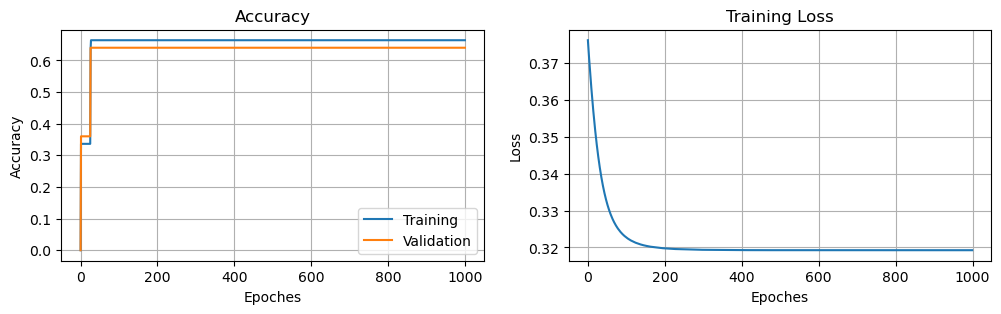

In [27]:
plt.figure(figsize=(12,3))
plt.subplot(1,2,2)
plt.plot(mlp.L)
plt.title('Training Loss')
plt.grid()
plt.xlabel('Epoches')
plt.ylabel('Loss')

# adding base condition to get initial accuracy of 0
mlp.A.insert(0,0)
mlp.validation_accuracy.insert(0,0)

plt.subplot(1,2,1)
plt.plot(mlp.A,label='Training')
plt.plot(mlp.validation_accuracy,label='Validation')
plt.title('Accuracy')
plt.grid()
plt.xlabel('Epoches')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

